# Financial Economics PS 8
## Maximilian Huber
This code is stored at https://github.com/MaximilianJHuber/NYU/blob/master/FinEcon%201/PS8.ipynb

## 5
I use the FredData package to directly load time series out of FRED:

In [17]:
using FredData
using Plots; pyplot();
f = Fred();

API key loaded.


In [18]:
recessions = get_data(f, "USREC", observation_start="1947-01-01", frequency = "q");

In [19]:
GDP = get_data(f, "GDPC1", observation_start="1947-01-01", frequency = "q");

### 5.1

In [20]:
P = [sum((recessions.df[:value][2:end] .== sprime) .* (recessions.df[:value][1:end-1] .== s)) 
    for s in [0., 1.], sprime in [0., 1.]]

P = P ./ sum(P,2)

2×2 Array{Float64,2}:
 0.954167  0.0458333
 0.261905  0.738095 

In [21]:
A = convert(Array{Float64, 2}, logm(P))

2×2 Array{Float64,2}:
 -0.0547774   0.0547774
  0.313014   -0.313014 

### 5.2


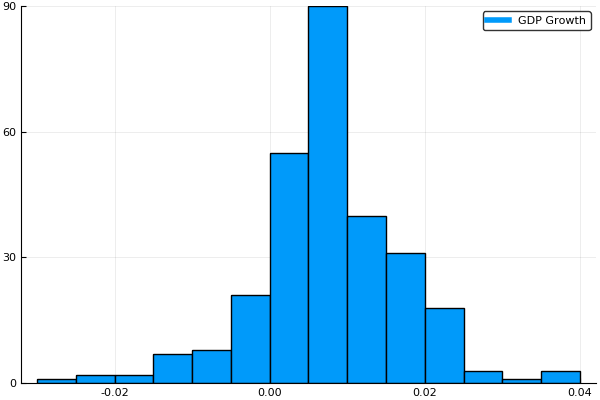

In [22]:
growth = diff(log.(GDP.df[:value]))
histogram(growth, label="GDP Growth")

In [155]:
(D, V) = eig(P');

The stationary distribution is:

In [156]:
π = V[:, 1] / sum(V[:, 1])

2-element Array{Float64,1}:
 0.851064
 0.148936

Lets find the $\kappa_2$ such that $\pi \cdot \kappa = \hat{\text{g}}$:

In [150]:
κ2 = -0.005
κ1 = (mean(growth) - π[2] * κ2) / π[1]
κ = [κ1, κ2]

2-element Array{Float64,1}:
  0.00997214
 -0.005     

### 5.3

$$y_{t+1} - y_t = \kappa \cdot \bar{z}_t + \sigma \Big(\bar{W}_{t+1} - \bar{W}_t\Big) $$
$$\bar{z}_{t+1} - \bar{z}_t = A' \bar{z} + |\sigma|\, \Delta(\bar{z}) \Big(\bar{W}_{t+1} - \bar{W}_t\Big)$$
with $y_t$ is log GDP and $\Delta(\bar{z}_t) = \Big(|\sigma|^2\Big)^{-1}\big(diag(\bar{z}_t) - \bar{z}_t\bar{z}'_t\big)\kappa'$.

Since we did not estimate $\sigma$, I just choose one.

In [151]:
function Wonham(growth, κ; σ = .01)
    zhat = zeros(length(growth), 2)
    zhat[1, :] = 1/2

    for t in 1:length(growth)-1
        zhat[t+1, :] = zhat[t, :] + 
            A' * zhat[t, :] + 
            ((σ^2)^(-1) * (diagm(zhat[t, :]) - zhat[t, :] * zhat[t, :]') * κ) * 
            (growth[t] - κ' * zhat[t, :])
        zhat[t+1, :] = min.(max.(zhat[t+1, :], 0), 1)
        zhat[t+1, :] = zhat[t+1, :] / sum(zhat[t+1, :])
    end
    return zhat
end

Wonham (generic function with 1 method)

With $\sigma = 0.01$:


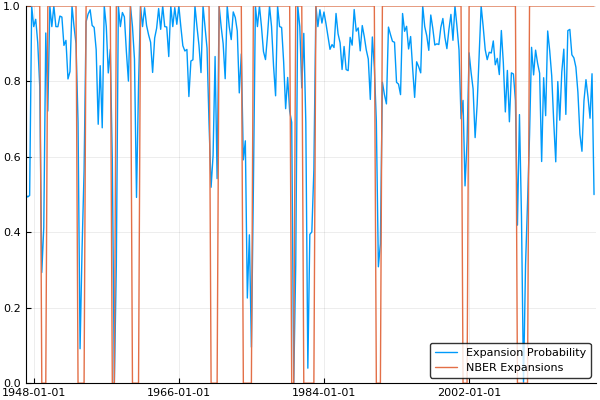

In [152]:
plot(GDP.df[:date], Wonham(growth, κ)[:, 1], ylim=[0, 1], label="Expansion Probability")
plot!(recessions.df[:date], 1 .- recessions.df[:value], label="NBER Expansions")

With the alternative $\kappa$:


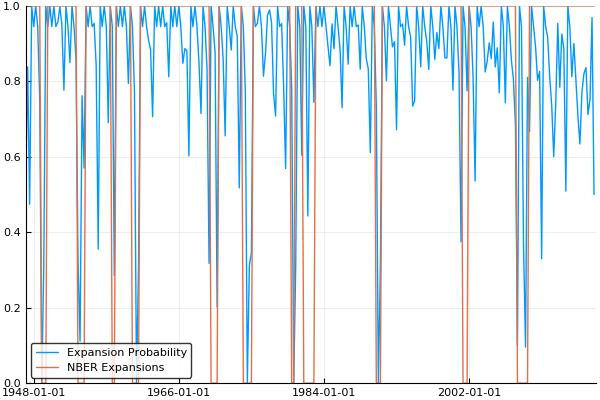

In [153]:
altκ = [(mean(growth) - π[2] * -0.02) / π[1], -0.02]
plot(GDP.df[:date], Wonham(growth, altκ)[:, 1], ylim=[0, 1], label="Expansion Probability")
plot!(recessions.df[:date], 1 .- recessions.df[:value], label="NBER Expansions")

Again with the original $\kappa$, but double variance:


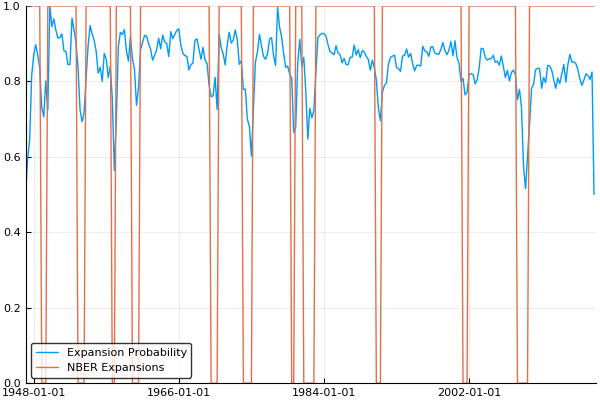

In [154]:
plot(GDP.df[:date], Wonham(growth, κ, σ = 0.02)[:, 1], ylim=[0, 1], label="Expansion Probability")
plot!(recessions.df[:date], 1 .- recessions.df[:value], label="NBER Expansions")

So yes, the answers differ rather significantly. The choice of variance is critical!